In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, edc, cpr, decimate, symbolSync #, fourthPowerFOE, dbp, cpr
from optic.models import phaseNoise, pdmCoherentReceiver#, manakovSSF
from optic.modelsGPU import manakovSSF
from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import mimoAdaptEqualizer
from optic.metrics import fastBERcalc, monteCarloGMI, signal_power

from scipy import signal
import scipy.constants as const

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# Simulation of coherent WDM systems

## Coherent WDM system

### Transmitter

In [264]:
help(simpleWDMTx)

Help on function simpleWDMTx in module utils.tx:

simpleWDMTx(param)
    Simple WDM transmitter
    
    Generates a complex baseband waveform representing a WDM signal with arbitrary number of carriers
    
    :param.M: QAM order [default: 16]
    :param.Rs: carrier baud rate [baud][default: 32e9]
    :param.SpS: samples per symbol [default: 16]
    :param.Nbits: total number of bits per carrier [default: 60000]
    :param.pulse: pulse shape ['nrz', 'rrc'][default: 'rrc']
    :param.Ntaps: number of coefficients of the rrc filter [default: 4096]
    :param.alphaRRC: rolloff do rrc filter [default: 0.01]
    :param.Pch_dBm: launched power per WDM channel [dBm][default:-3 dBm]
    :param.Nch: number of WDM channels [default: 5]
    :param.Fc: central frequency of the WDM spectrum [Hz][default: 193.1e12 Hz]
    :param.freqSpac: frequency spacing of the WDM grid [Hz][default: 40e9 Hz]
    :param.Nmodes: number of polarization modes [default: 1]



In [265]:
help(manakovSSF)

Help on function manakovSSF in module utils.modelsGPU:

manakovSSF(Ei, Fs, paramCh)
    Manakov model split-step Fourier (symmetric, dual-pol.)
    
    :param Ei: input signal
    :param Fs: sampling frequency of Ei [Hz]
    :param paramCh: object with physical parameters of the optical channel
    
    :paramCh.Ltotal: total fiber length [km][default: 400 km]
    :paramCh.Lspan: span length [km][default: 80 km]
    :paramCh.hz: step-size for the split-step Fourier method [km][default: 0.5 km]
    :paramCh.alpha: fiber attenuation parameter [dB/km][default: 0.2 dB/km]
    :paramCh.D: chromatic dispersion parameter [ps/nm/km][default: 16 ps/nm/km]
    :paramCh.gamma: fiber nonlinear parameter [1/W/km][default: 1.3 1/W/km]
    :paramCh.Fc: carrier frequency [Hz] [default: 193.1e12 Hz]
    :paramCh.amp: 'edfa', 'ideal', or 'None. [default:'edfa']
    :paramCh.NF: edfa noise figure [dB] [default: 4.5 dB]    
    
    :return Ech: propagated signal



## Polarization multiplexed WDM signal

**signal generation**

In [5]:
# Parâmetros do transmissor:
param = parameters()
param.M   = 64           # ordem do formato de modulação
param.Rs  = 32e9         # taxa de sinalização [baud]
param.SpS = 16           # número de amostras por símbolo
param.Nbits = 600000     # número de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 1024       # número de coeficientes do filtro RRC
param.alphaRRC = 0.01    # rolloff do filtro RRC
param.Pch_dBm = 1       # potência média por canal WDM [dBm]
param.Nch     = 11       # número de canais WDM
param.Fc      = 193.1e12 # frequência central do espectro WDM
param.freqSpac = 37.5e9    # espaçamento em frequência da grade de canais WDM
param.Nmodes = 2         # número de modos de polarização

sigWDM_Tx, symbTx_, param = simpleWDMTx(param)

freqGrid = param.freqGrid

channel 0	 fc : 192.9125 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 0	 power: 1.00 dBm

channel 1	 fc : 192.9500 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 1	 power: 1.00 dBm

channel 2	 fc : 192.9875 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 2	 power: 1.00 dBm

channel 3	 fc : 193.0250 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 3	 power: 1.00 dBm

channel 4	 fc : 193.0625 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 4	 power: 1.00 dBm

channel 5	 fc : 193.1000 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 5	 power: 1.00 dBm

channel 6	 fc : 193.1375 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 6	 power: 1.00 dBm

channel 7	 fc : 193.1750 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 7	 power: 1.00 dBm

channel 8	 fc : 193.2125 THz
  mode #0	 power: -2.01 dBm
  mode #1	 power: -2.01 dBm
channel 8	 

In [267]:
#%lprun -f simpleWDMTx simpleWDMTx(param)

**Nonlinear fiber propagation with the split-step Fourier method**

In [6]:
linearChannel = False

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800  # km
paramCh.Lspan  = 50    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)

if linearChannel:
    paramCh.hz = paramCh.Lspan 
    paramCh.gamma = 0  

Fs = param.Rs*param.SpS
sigWDM, paramCh = manakovSSF(sigWDM_Tx, Fs, paramCh) 


receivedSignal = sigWDM.copy()
transmSymbols  = symbTx_.copy()

In [269]:
#%lprun -f manakovSSF manakovSSF(sigWDM_Tx, Fs, paramCh)

**Optical WDM spectrum before and after transmission**

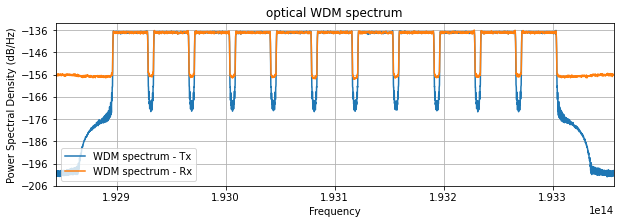

In [7]:
# plot psd
plt.figure()
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

Demodulating channel #5 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 0.00 kHz, FO: 0.00 MHz



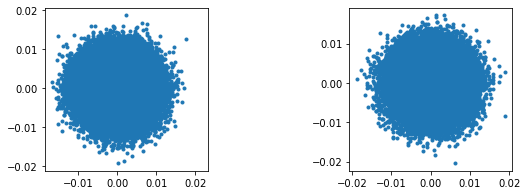

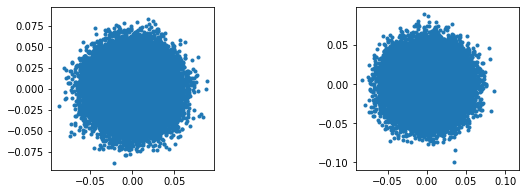

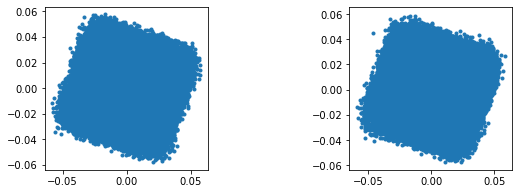

In [8]:
### Receiver

# parameters
chIndex  = 5    # index of the channel to be demodulated
plotPSD  = True

Fa = param.SpS*param.Rs
Fc = paramCh.Fc
Ta = 1/Fa
mod = QAMModem(m=param.M)

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = transmSymbols[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 0*64e6                # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 0*10e3                  # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig = π/3, Rdx=1, Rdy=1)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# Rx filtering

# Matched filtering
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

# CD compensation
sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fa)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sigRx[0::param.SpS,0].real, sigRx[0::param.SpS,0].imag,'.')
ax1.axis('square');
ax2.plot(sigRx[0::param.SpS,1].real, sigRx[0::param.SpS,1].imag,'.')
ax2.axis('square');

In [9]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = param.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

In [10]:
# symbol synchronization
symbTx  = transmSymbols[:,:,chIndex]
symbTx_ = symbolSync(sigRx, symbTx, 2)

In [11]:
#from numpy.matlib import repmat
#from tqdm.notebook import tqdm

x = sigRx
d = symbTx_

x = x.reshape(len(x),2)/np.sqrt(signal_power(x))
d = d.reshape(len(d),2)/np.sqrt(signal_power(d))



nlms - training stage #0


nlms pre-convergence training iteration #0
nlms MSE = 0.088190.
nlms pre-convergence training iteration #1
nlms MSE = 0.027367.
nlms pre-convergence training iteration #2
nlms MSE = 0.027227.
nlms pre-convergence training iteration #3
nlms MSE = 0.027215.
nlms pre-convergence training iteration #4
nlms MSE = 0.027207.



dd-lms - training stage #1
dd-lms MSE = 0.014997.


rls - training stage #0


rls pre-convergence training iteration #0
rls MSE = 0.023273.



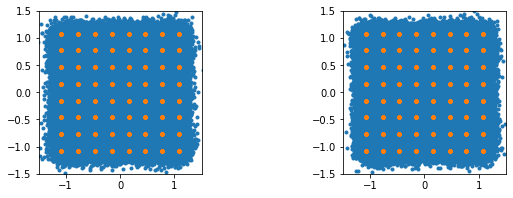

In [12]:
M = 64
mod = QAMModem(m=M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [5e-3, 1e-3]
#paramEq.lambdaRLS = 0.97
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','dd-lms']
paramEq.M     = M
paramEq.L = [20000, 80000]

# from numpy.matlib import repmat
# y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(np.matlib.repmat(x,1,3),\
#                                            dx=np.matlib.repmat(d,1,3),\
#                                             paramEq=paramEq)

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)


paramEq = parameters()
paramEq.nTaps = 3
paramEq.SpS   = 1
paramEq.lambdaRLS = 0.97
paramEq.numIter = 1
paramEq.storeCoeff = False
paramEq.alg   = ['rls']
paramEq.M     = M

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(y_EQ, dx=d, paramEq=paramEq)

fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_EQ[discard:-discard,0].real, y_EQ[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_EQ[discard:-discard,1].real, y_EQ[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

In [276]:
#%lprun -f mimoAdaptEqualizer mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

     pol.X     pol.Y      
SER: 2.67e-01, 2.63e-01
BER: 4.80e-02, 4.73e-02
SNR: 16.16 dB, 16.20 dB
GMI: 4.96 bits, 4.98 bits


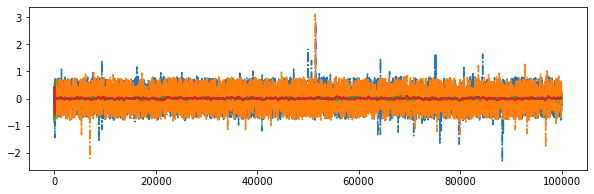

In [13]:
#constSymb  = mod.constellation/np.sqrt(mod.Es)
#y_CPR, ϕ, θ = cpr(y_EQ, 80, M, np.matlib.repmat(d,1,3), pilotInd=np.arange(0,len(y_EQ), 50))
y_CPR, ϕ, θ = cpr(y_EQ, 140, M, d, pilotInd=np.arange(0,len(y_EQ), 20))

plt.plot(ϕ,'-.', θ,'-')

discard = 2000
ind = np.arange(discard, d.shape[0]-discard)

# BER, SER, SNR = fastBERcalc(y_CPR[ind,:], np.matlib.repmat(d[ind,:],1,3), mod)
# GMI,_    = monteCarloGMI(y_CPR[ind,:], np.matlib.repmat(d[ind,:],1,3), mod)

BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], mod)
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], mod)

print('     pol.X     pol.Y      ')
print('SER: %.2e, %.2e'%(SER[0], SER[1]))
print('BER: %.2e, %.2e'%(BER[0], BER[1]))
print('SNR: %.2f dB, %.2f dB'%(SNR[0], SNR[1]))
print('GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))

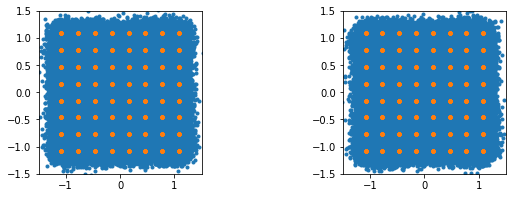

In [285]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1000

ax1.plot(y_CPR[discard:-discard,0].real, y_CPR[discard:-discard,0].imag,'.')
ax1.plot(d[:,0].real, d[:,0].imag,'.')
ax1.axis('square')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(y_CPR[discard:-discard,1].real, y_CPR[discard:-discard,1].imag,'.')
ax2.plot(d[:,1].real, d[:,1].imag,'.')
ax2.axis('square')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5);

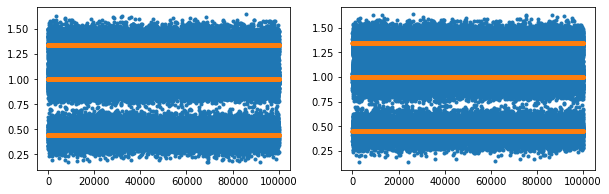

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
discard = 1

ax1.plot(np.abs(y_EQ[discard:-discard,0]),'.')
ax1.plot(np.abs(d[:,0]),'.');
#ax1.axis('square')
#ax1.set_xlim(-1.5, 1.5)
#ax1.set_ylim(-1.5, 1.5)

ax2.plot(np.abs(y_EQ[discard:-discard,1]),'.')
ax2.plot(np.abs(d[:,1]),'.');
#ax2.axis('square')
#ax2.set_xlim(-1.5, 1.5)
#ax2.set_ylim(-1.5, 1.5);

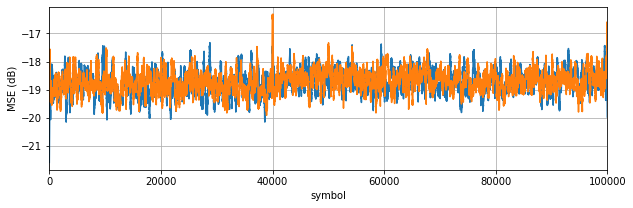

In [133]:
Nav = 200
h = np.ones(Nav)/Nav

plt.figure()
for ind in range(0, errSq.shape[0]):
    err_ = errSq[ind,:]
    plt.plot(10*np.log10(firFilter(h, err_)));
    
# for ind in range(0, errSq.shape[0]):
#     err_ = errSq[ind,:]
#     plt.plot(10*np.log10(np.convolve(h, err_)));

plt.grid()
plt.xlim(0,errSq.shape[1])
plt.xlabel('symbol')
plt.ylabel('MSE (dB)');

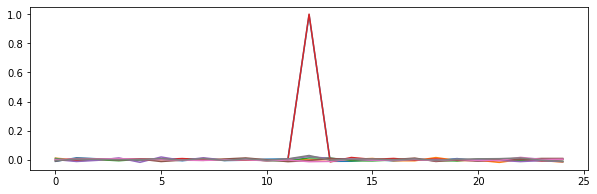

In [222]:
plt.plot(H.real.T,'-');
plt.plot(H.imag.T,'-');

# plt.stem(H[0,:].real.T,linefmt='r');
# plt.stem(H[3,:].imag.T,linefmt='b');

In [23]:
#%load_ext autoreload
#%autoreload 2

In [214]:
#%lprun -f monteCarloGMI monteCarloGMI(y_EQ[ind,:], d[ind,:], mod)

In [217]:
#%lprun -f fastBERcalc fastBERcalc(y_EQ[ind,:], d[ind,:], mod)

In [207]:
#%lprun -f cpr cpr(y_EQ, 25, M, d, pilotInd=np.arange(0,len(y_EQ), 50))

In [28]:
#!pip install --upgrade numba --user

!pip install line_profiler --user